names = ['255', '267', '278', '288', '292', '459', '463', '464', '473', '4935', '4938', '4942', '4944', '4946', '4953', '4957', '4958', '4966', '4970', '4976', '504', '523', '6436', '6444', '6459', '6461', '6465', '6473']
28 darab annotalt szeletunk van.


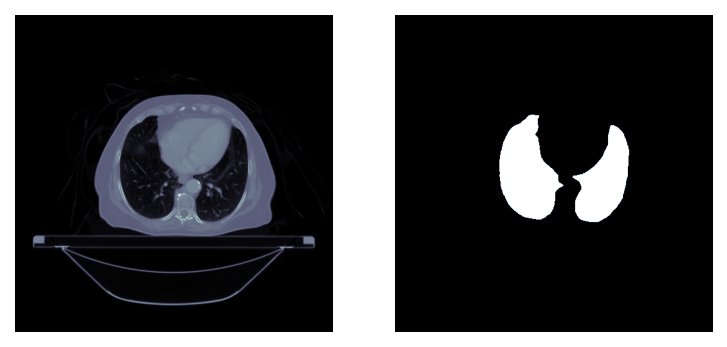

['7.3', '7.31', '7.26', '7.51', '7.35', '5.82', '5.73', '6.06', '5.96', '8.03', '9.88', '9.01', '10.6', '7.84', '5.55', '6.87', '7.62', '8.39', '6.24', '6.56', '7.94', '7.92', '11.3', '12.1', '10.6', '10.4', '10.7', '9.99']


In [352]:
%run ./test_mask.ipynb

In [353]:
#%matplotlib inline
import math
import pydicom
import numpy as np
from os.path import dirname, join
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.ndimage import gaussian_filter
from skimage.morphology import flood_fill

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

dcm = pydicom.dcmread("../data/pelda2.dcm")

In [354]:
def plot_two_cols(fig1, fig2, cmap=plt.cm.bone):
    plt.rcParams["figure.figsize"] = (10,10)
    fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150)
    [axi.set_axis_off() for axi in axs]
    axs[0].imshow(fig1, cmap=cmap)
    axs[1].imshow(fig2, cmap=cmap)

In [355]:
# i need these from the dicomheader to calculate HU as HU = grayvalue * slope + intercept
intercept = int(dcm.RescaleIntercept)
slope = int(dcm.RescaleSlope)
pixel_spacing = float(dcm.PixelSpacing[0])
mypixels = dcm.pixel_array * slope + intercept

#mypixels=images[7]


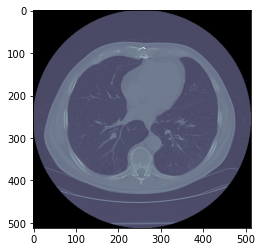

In [356]:
plt.imshow(mypixels, cmap=plt.cm.bone) 

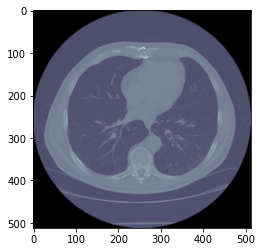

In [357]:
# gaussian smoothing 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
# TODO: how much sigma to use
from scipy.ndimage import gaussian_filter
gaussed = gaussian_filter(mypixels, sigma=pixel_spacing)
plt.imshow(gaussed,  cmap=plt.cm.bone )

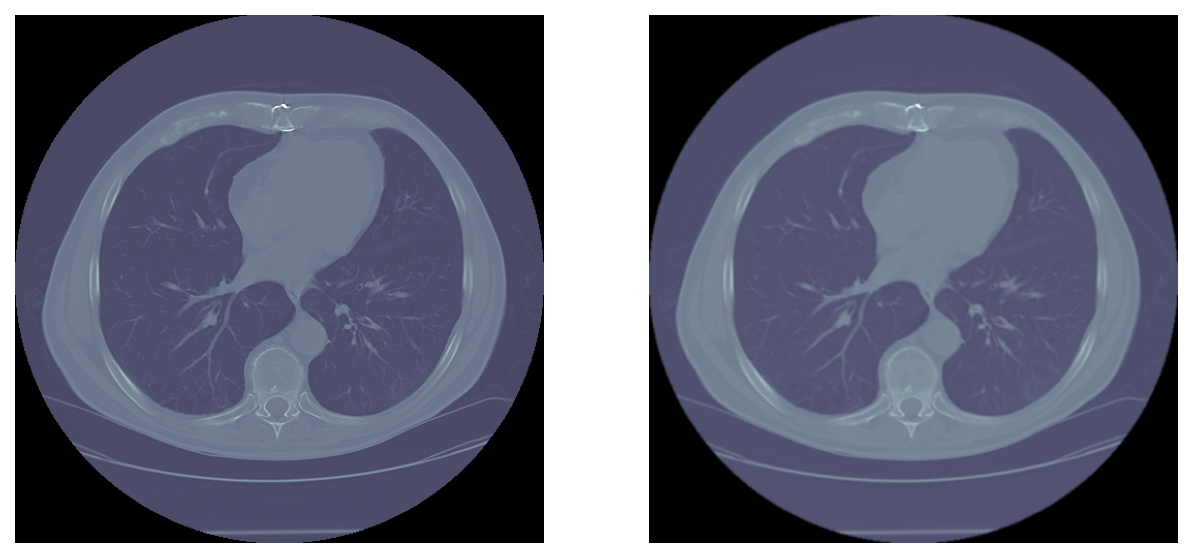

In [358]:
plot_two_cols(mypixels, gaussed)

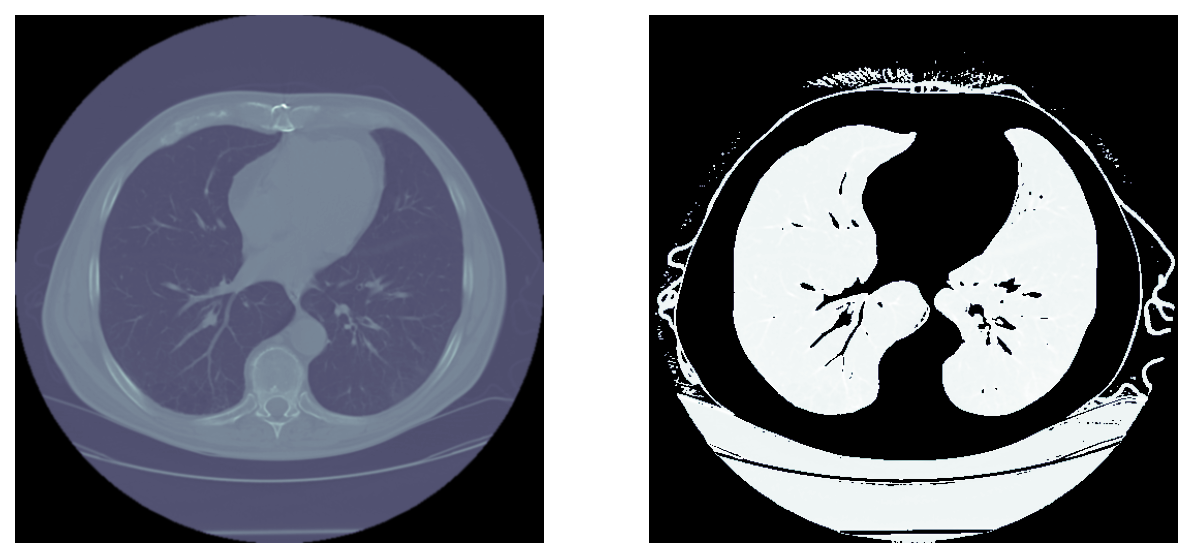

In [359]:
plt.rcParams["figure.figsize"] = (10,10)
# gray level tresholding
# TODO: experiment with other than -500
tresholded = gaussed.copy()

mask = (tresholded > -500) | (tresholded < -980)
tresholded[mask] = -10000
_ = plot_two_cols(gaussed, tresholded)

In [360]:
hstp = dcm.pixel_array * slope + intercept
#plt.hist(hstp)
plt.show()

In [361]:
hst = (hstp < -1500) & (hstp != -1024) & (hstp != -1000) 
#plt.imshow(hstp[hst])


#plt.hist(hst, bins=1000)
#plt.show()

In [362]:
hst

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

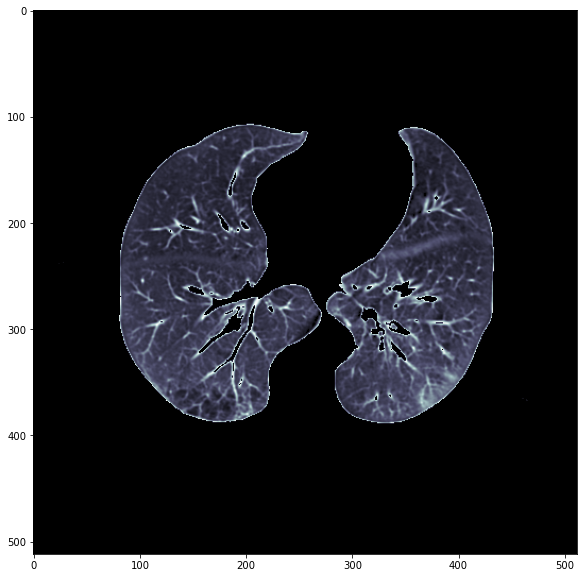

In [363]:

# floodfill non-lung region
# ASK: should i implement this manually?
from skimage.morphology import flood_fill
filled = tresholded.copy()
xmax, ymax = filled.shape
i = 0


#flood_fill(filled, (i, 0), -3000, tolerance=2500,connectivity=1, inplace=True) # int(ymax*0.15)
#flood_fill(filled, (i, ymax-1), -3000, tolerance=2500,connectivity=1, inplace=True) # int(ymax*0.85)

flood_fill(filled, (xmax-1, ymax-1), -3000, tolerance=2500,connectivity=1, inplace=True) # int(xmax*0.85)
flood_fill(filled, (xmax-1, i), -3000, tolerance=2500,connectivity=1, inplace=True) # int(xmax*0.85)


    
filled[filled == -10000] = -1024
filled[filled == -3000] = -1024
#%matplotlib nbagg
plt.imshow(filled,  cmap=plt.cm.bone )

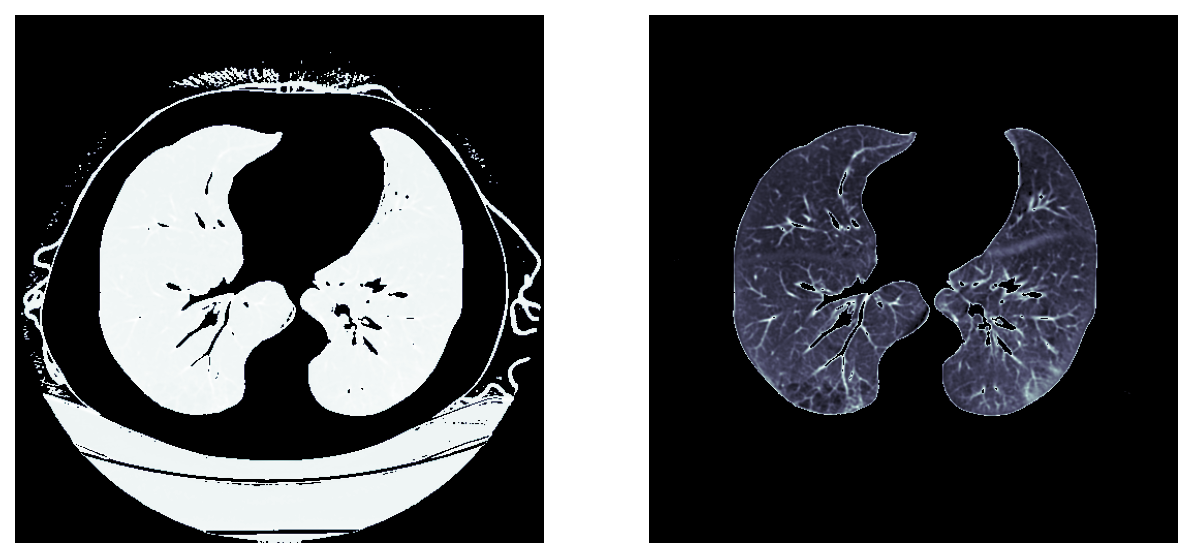

In [364]:
plot_two_cols(tresholded, filled)

In [365]:
filled

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

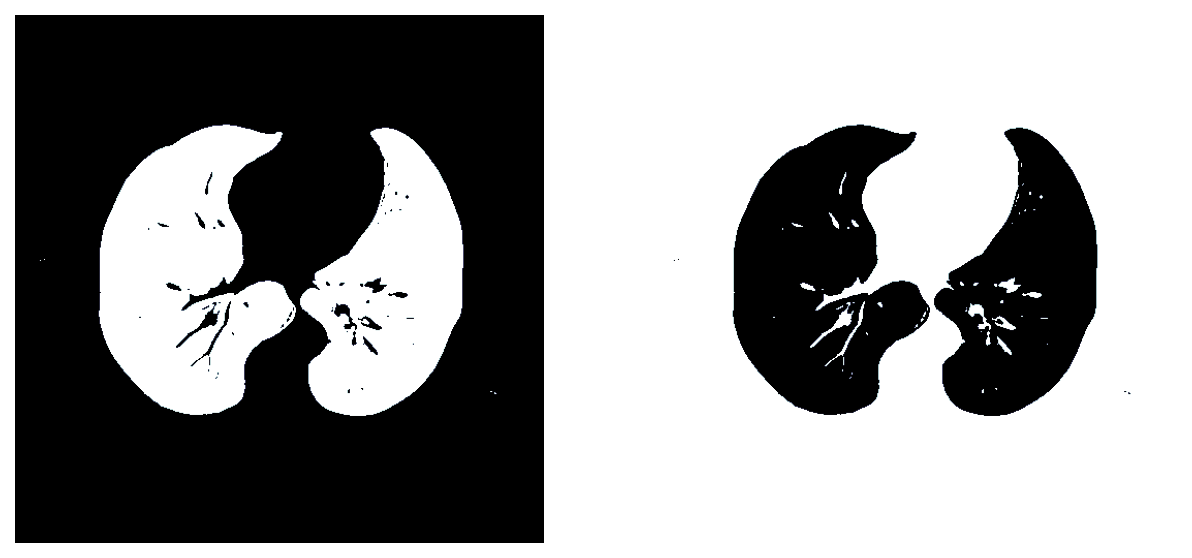

In [366]:
lung_mask = (filled != -1024)
non_lung_mask = (filled == -1024)

plot_two_cols(lung_mask, non_lung_mask)

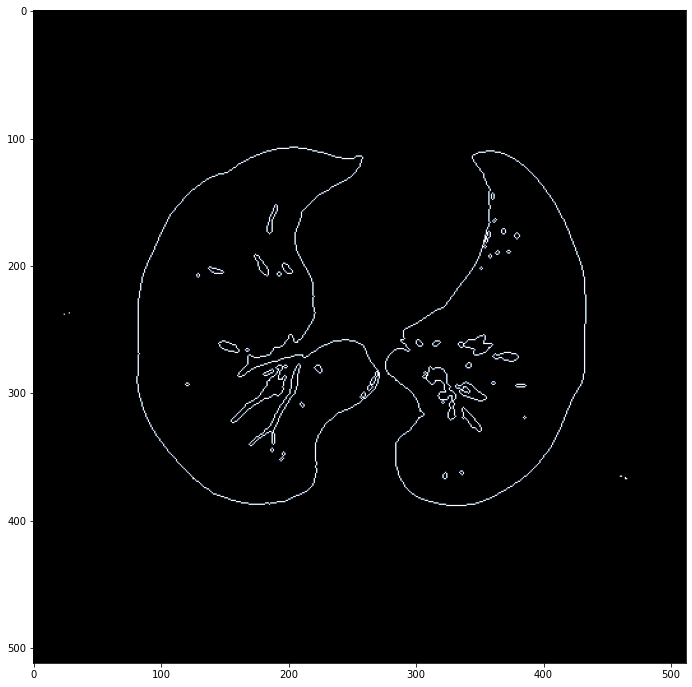

In [367]:
# Border tracing algo
import skimage.segmentation as seg

boundaries = seg.find_boundaries(lung_mask, mode="inner")
plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(boundaries, cmap=plt.cm.bone)

In [368]:
def get_left_start_points(mymask, debug=False):
    halfdim = int(mymask.shape[0]/2)
    for i in range(mymask.shape[0]):
        if debug:
            print('mymask[',halfdim,'][',i,'],)=',mymask[halfdim][i])
        if mymask[halfdim][i]:
            return (i,halfdim)

def get_right_start_points(mymask):
    limit = mymask.shape[0]
    halfdim = int(limit/2)
    for i in range(limit):
        if mymask[halfdim,limit-1-i]:
            return (limit-1-i,halfdim)

In [369]:
# p1 = get_border_from_startpoint(start_points[0], boundaries)
# p2 = get_border_from_startpoint(start_points[1], boundaries)
# plot_two_cols(p1, p2)

In [370]:
marching_step_lenght = 5


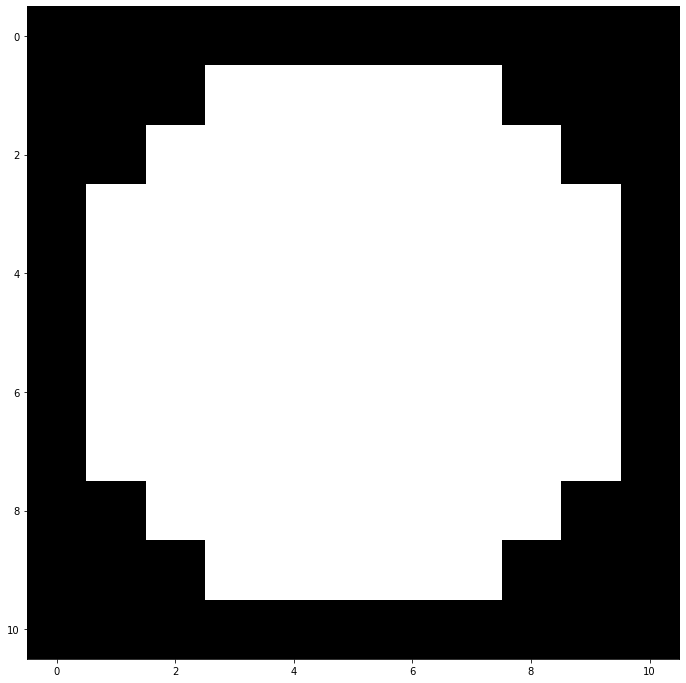

In [371]:
from skimage.draw import circle_perimeter, circle
circ = np.zeros((11, 11), dtype=np.bool)
rr, cc = circle(5, 5, 5)
circ[rr, cc] = True
circ
plt.imshow(circ, cmap=plt.cm.bone)


Begin
    {Initialization: find a pixel in P, initialize B, define M(p) to be the Moore neighborhood of the current pixel p}
    1. Set B to be empty.
    2. From bottom to top and left to right scan the cells of T until a pixel s of P is found (until the current pixel p=s is a black pixel of P), insert s in B. Let b denote the current boundary point, i.e., b=s.
    3. Backtrack (move the current pixel to the pixel from which s was entered) and advance the current pixel p being examined to the next clockwise pixel in M(b).
    while p is not equal to s do
        if p is black, insert p in B, set b=p and backtrack (move the current pixel to the pixel from
        which p=b was entered);
        else advance the current pixel p to the next clockwise pixel in M(b). end while
End

In [372]:
def neigh(s,l,T):
    directions = [(-1,0),(-1,-1),(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1)]
    dire = tuple(np.subtract(l,s))
    ind = directions.index(dire)
    directions = directions[ind:] + directions[:ind]
    for i, dire in enumerate(directions):
        new = tuple(np.add(s,dire))
        #print('dire=',dire,'new=',new,'T=',T[new[1],new[0]])
        if T[new[1],new[0]] == True:
            last = tuple(np.add(s,directions[i-1]))
            return (new, last)
    print('couldnt return neighbour:', s,l,T)


# def find_pixel(grid):
#     ind = np.nonzero(grid)
#     x = ind[0][0]
#     y = ind[1][0]
#     if x == 0 and y == 0:
#         raise ValueError('Cant backtrack. First pixel is in the topleft corner.')
#     if x == 0 and y > 0:
#         last = (grid.shape[0]-1, y-1)
#         print("baj van")
#         return ((x,y),last)
#     last = (x - 1, y)
#     print('returned in find_pixel:', ((x,y),last))
#     return ((x,y),last)

def moore_neighbor_tracing(T,start,l):
    B = [start]
    b = start
    b,l = neigh(b, l, T)
    B.append(b)
    while b != start:
        b,l = neigh(b, l, T)
        if b in B:
            print('possible trouble')
            break
        B.append(b)
    return B
        

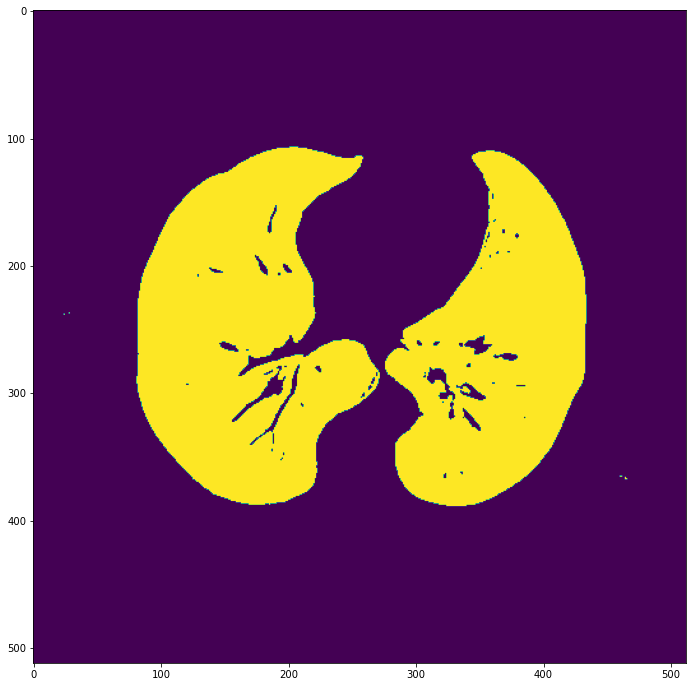

In [373]:
#%matplotlib widget
plt.imshow(lung_mask)#[90:110,190:220]

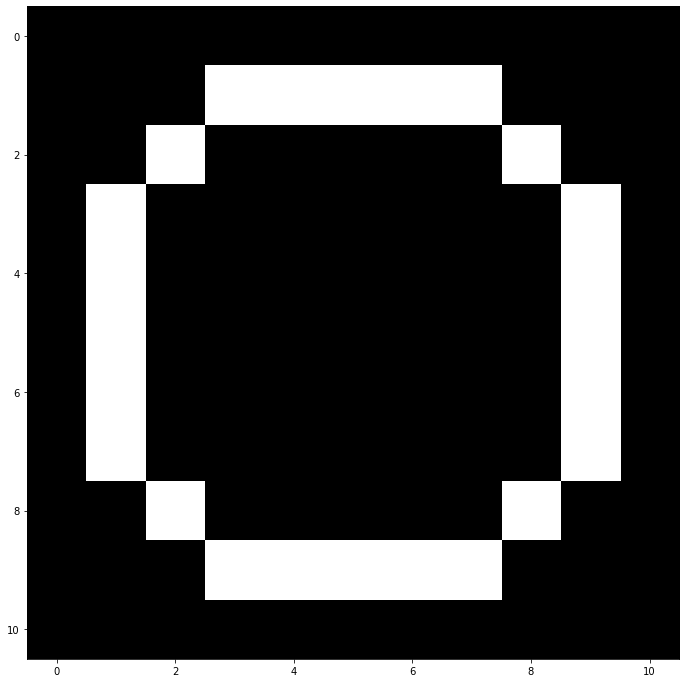

In [374]:
bou = seg.find_boundaries(circ, mode="inner")
plt.imshow(bou, cmap=plt.cm.bone)

In [375]:
def make_mask_from_border(border, shape):
    newmask = np.zeros(shape=shape, dtype=bool)
    for v in border:
        newmask[v[1],v[0]] = True
    return newmask

circles_start= (1, 5)
possible trouble


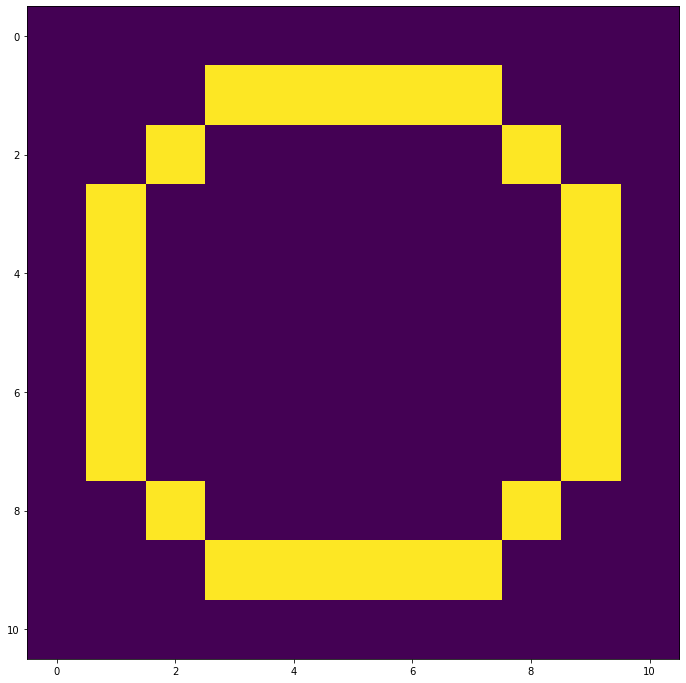

In [376]:
circles_start = get_left_start_points(bou)
print('circles_start=',circles_start)
circles_border = moore_neighbor_tracing(bou, circles_start, (circles_start[0]-1,circles_start[1]-1))
plt.imshow(make_mask_from_border(circles_border, bou.shape))

In [377]:
def isLeft(start, end, point):
    # point p0(x0, y0) to p1(x1, y1) tooo p2(x2, y2) 
    return  ((end[0] - start[0])*(point[1] - start[1]) - (point[0] - start[0])*(end[1] - start[1])) > 0 ;
    

# def non_adaptive(border):
#     STEP_LENGTH = 5
#     bord = border.copy() 
#     res = [bord.pop(0)]
#     print(id(border), id(bord))
#     line_start = None
#     line_end = None
#     while len(bord):
#         print('res=',res)
#         print('bord=', bord)
#         line_start = res[-1]
#         line_end = bord.pop(0)
#         for i in range(STEP_LENGTH - 2):
#             newpoint = bord.pop(0)
#             if newpoint == border[-1]:
#                 print('HEYYO UTSO')
#                 break
#             print('isRight(line_start, line_end, newpoint):',line_start,line_end, newpoint, isRight(line_start, line_end, newpoint))
#             if isRight(line_start, line_end, newpoint):
#                 print('line:',line_start,line_end,'"s right point:', newpoint)
#                 line_end = newpoint
#         res.append(line_end)
#         print(line_end, 'appended')
#     return res


def non_adaptive(border, STEP_LENGTH=5):
    res = [border[0]]
    start_ind = 0
    
    while border[start_ind] !=  border[-1]:
        line_start = border[start_ind]
        line_end = border[start_ind+1]

        for i in range(start_ind+2, start_ind+STEP_LENGTH):
            #print(i, line_start, line_end, border[i])
            try:
                if border[i] == border[-1]:
                    print('breaked')
                    res.append(border[i])
                    return res
            except IndexError:
                return res
            if isLeft(line_start, line_end, border[i]):

                line_end = border[i]
                start_ind = i
        start_ind = border.index(line_end)
        res.append(line_end)
    return res
    




In [378]:
print(isLeft((0,0), (2,3), (2, 2)))

False


[(1, 5), (1, 4), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 8), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 8), (1, 7), (1, 6)]


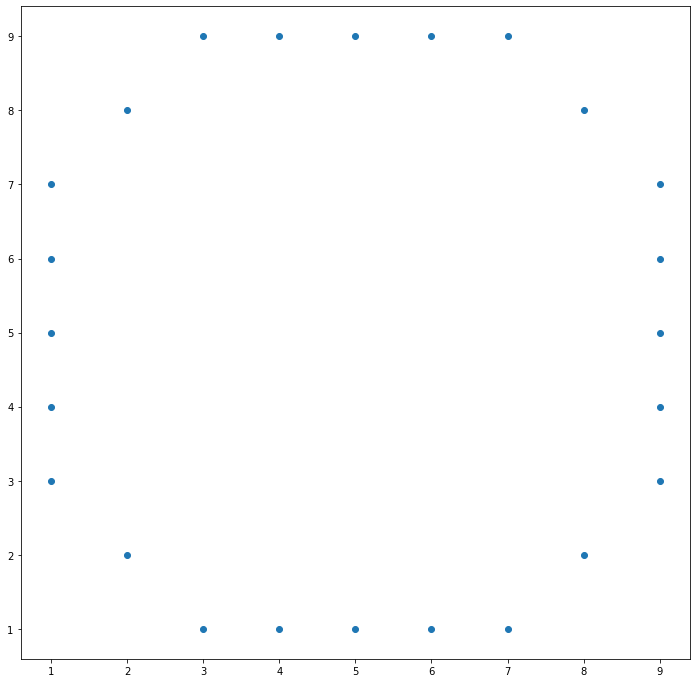

In [379]:
print(circles_border)
x, y = zip(*circles_border)
plt.scatter(x,y)

breaked
[(1, 5), (3, 1), (4, 1), (8, 2), (9, 6), (6, 9), (2, 8), (1, 6)]


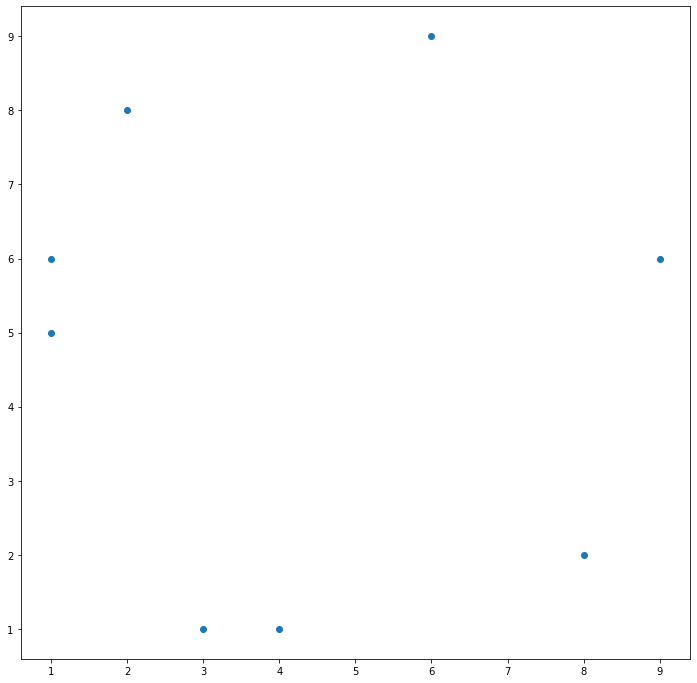

In [380]:
asd = non_adaptive(circles_border)
print(asd)
x, y = zip(*asd)
plt.scatter(x,y)

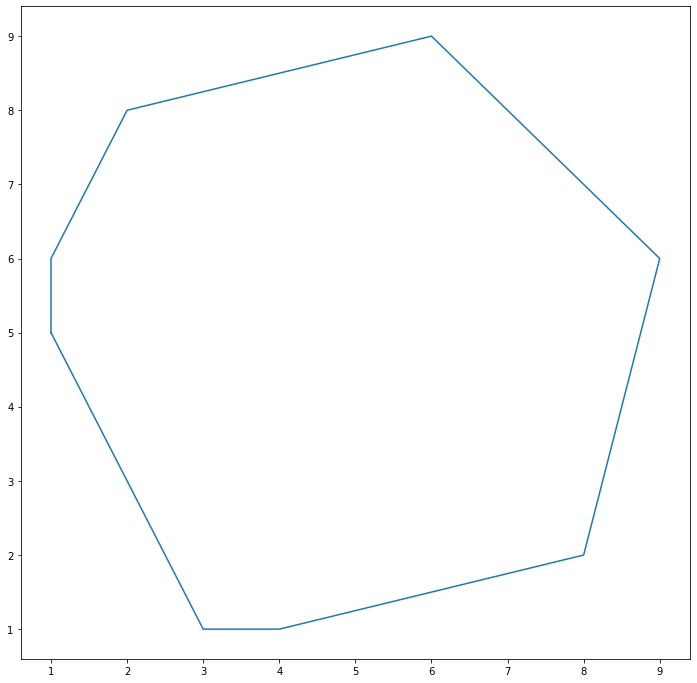

In [381]:

asd.append(asd[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*asd)
plt.plot(xs,ys) 

left: (82, 256) right: (432, 256)
possible trouble
possible trouble


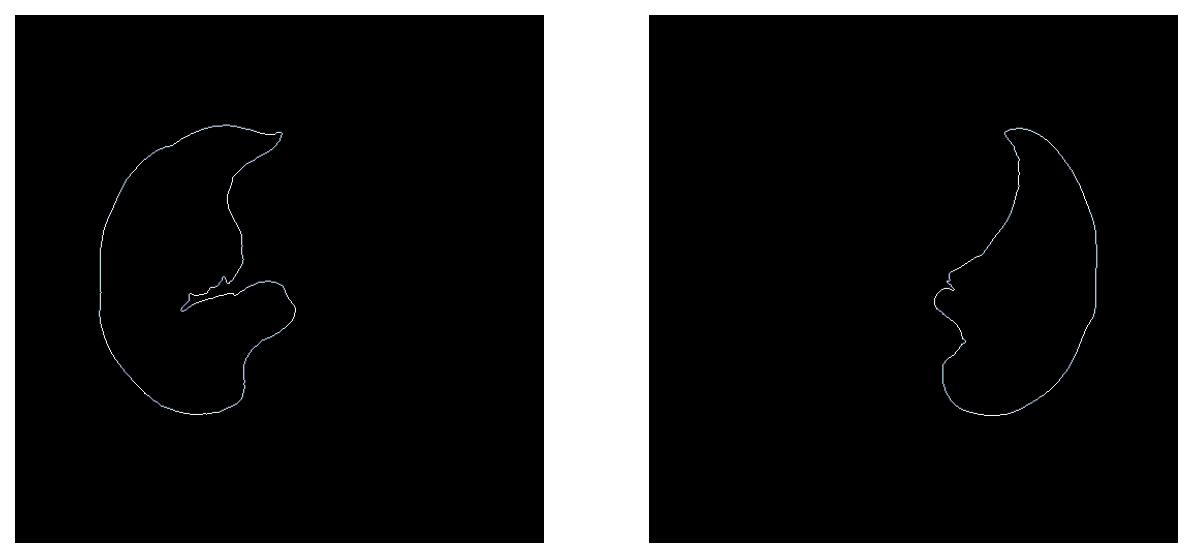

In [382]:
%matplotlib inline
lp = get_left_start_points(lung_mask)
rp = get_right_start_points(lung_mask)
print('left:', lp, 'right:', rp)

leftie_border = moore_neighbor_tracing(boundaries, lp, (lp[0]-1,lp[1]-1))
rightie_border = moore_neighbor_tracing(boundaries, rp, (rp[0]+1,rp[1]-1))

leftie = make_mask_from_border(leftie_border, lung_mask.shape)
rightie = make_mask_from_border(rightie_border, lung_mask.shape)

#plt.imshow(rightie)
plot_two_cols(leftie, rightie)

In [383]:

leftie_border_vis = leftie_border.copy()
leftie_border_vis.append(leftie_border_vis[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*leftie_border_vis)
orgleftvis = plt.plot(xs,ys)

Error in callback <function flush_figures at 0x7f5fe1927b90> (for post_execute):


KeyboardInterrupt: 

breaked


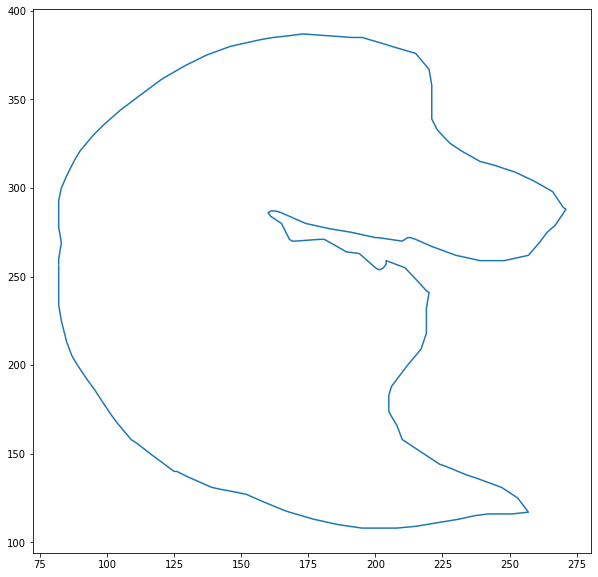

In [384]:
leftie_border_nonadapt = non_adaptive(leftie_border, 10)
#repeat the first point to create a 'closed loop'

xs, ys = zip(*leftie_border_nonadapt)
plt.plot(xs,ys)
#print(leftie_border_nonadapt)

In [385]:
myboundary = np.logical_or(leftie, rightie)

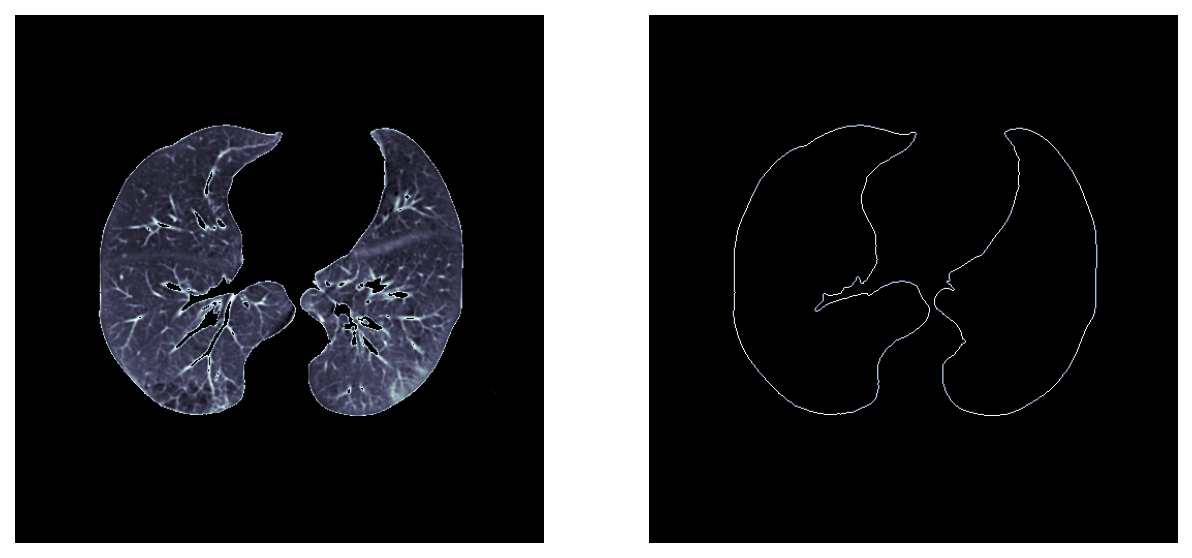

In [386]:
# a jobboldali kellene rarajzolnom a baloldalira.
plot_two_cols(filled, myboundary)

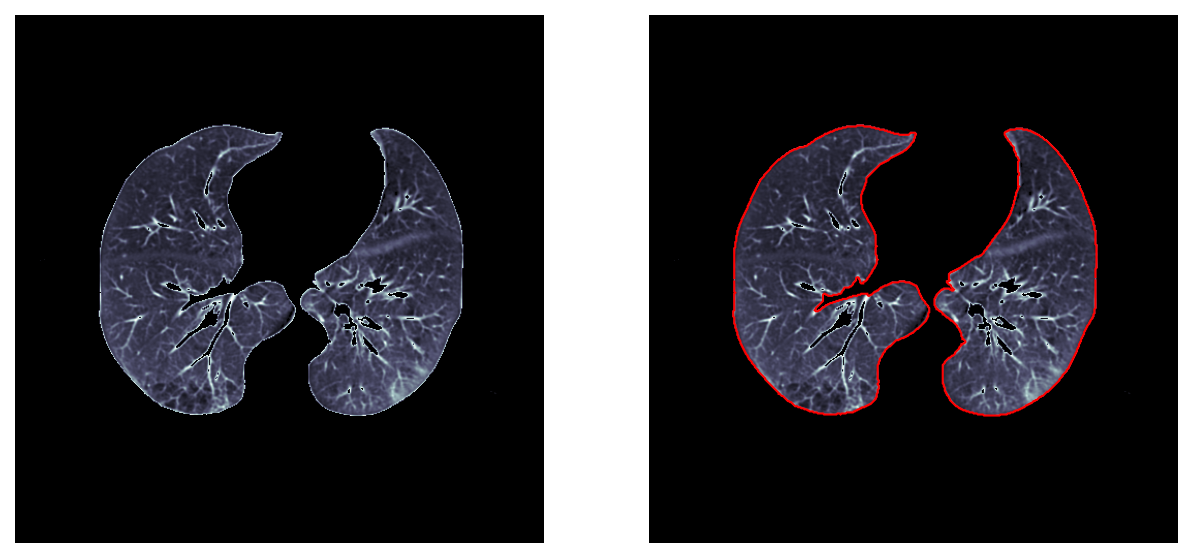

In [387]:
left_path = Path(leftie_border)
right_path = Path(rightie_border)
left_patch = PathPatch(left_path, fill=False, ec='red')
right_patch = PathPatch(right_path, fill=False, ec='red')
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150)
[axi.set_axis_off() for axi in axs]
axs[0].imshow(filled, cmap=plt.cm.bone)
axs[1].add_patch(left_patch)
axs[1].add_patch(right_patch)
axs[1].imshow(filled, cmap=plt.cm.bone)

In [388]:
def connect_nd(ends):
    d = np.diff(ends, axis=0)[0]
    j = np.argmax(np.abs(d))
    D = d[j]
    aD = np.abs(D)
    return ends[0] + (np.outer(np.arange(aD + 1), d) + (aD>>1)) // aD

In [513]:
def make_mask_from_nonadaptive_border(border, shape):
    border_nonadapt = border.copy()
    border_nonadapt.append(border_nonadapt[0])
    asd = [connect_nd(xy) for xy in list(zip(border_nonadapt[1:], border_nonadapt))]
    asd = make_mask_from_border(np.vstack(asd), shape)
    return asd

breaked
breaked


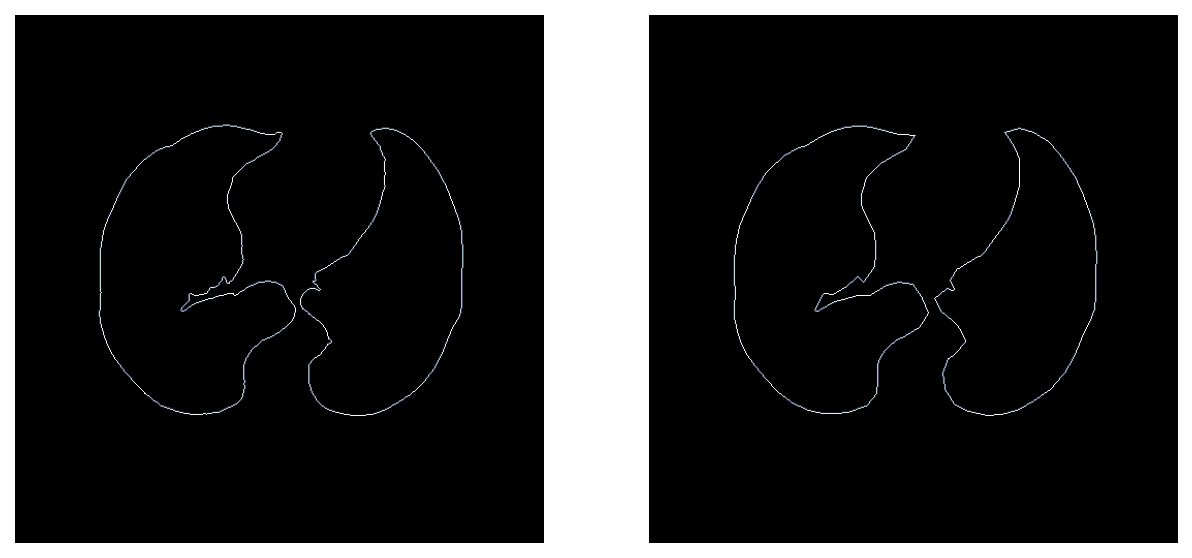

In [514]:
STEP_LENGTH = 15
leftie_border_nonadapt = non_adaptive(leftie_border, STEP_LENGTH)
rightie_border_nonadapt = non_adaptive(rightie_border, STEP_LENGTH)

leftie_nonadapt = make_mask_from_nonadaptive_border(leftie_border_nonadapt, lung_mask.shape)
rightie_nonadapt = make_mask_from_nonadaptive_border(rightie_border_nonadapt, lung_mask.shape)

nonadapt = np.logical_or(leftie_nonadapt, rightie_nonadapt)
plot_two_cols(myboundary, nonadapt)


In [391]:
np.nonzero(boundaries)

(array([107, 107, 107, ..., 388, 388, 388]),
 array([201, 202, 203, ..., 337, 338, 339]))

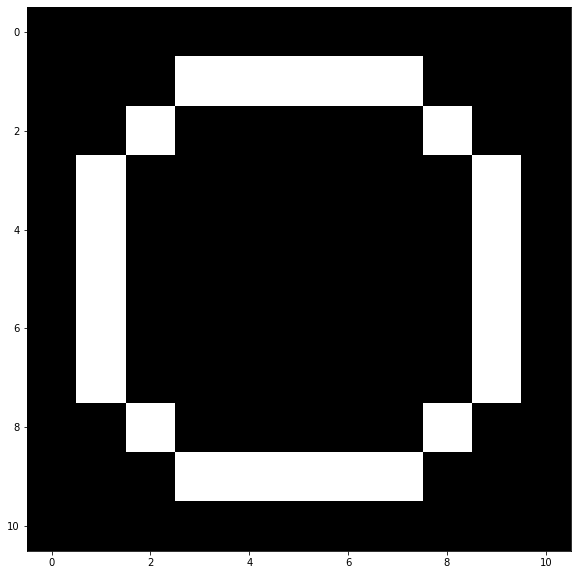

In [392]:
bou = seg.find_boundaries(circ, mode="inner")
plt.imshow(bou, cmap=plt.cm.bone)

In [393]:
# sp = get_start_points(bou)
# print('sp=',sp)
# bordam = get_border_from_startpoint(sp[0],bou)
# majmask = make_mask_from_border(bordam, shape=bou.shape)
# plt.imshow(majmask, cmap=plt.cm.bone)

In [394]:
# plt.imshow(boundaries[290:310, 250:270], cmap=plt.cm.bone)

In [395]:
# # boundaries
# print('start_points=',start_points)
# borderline = get_border_from_startpoint((19,2),boundaries[290:310, 250:270])
# left = make_mask_from_border(borderline, shape=boundaries[290:310, 250:270].shape)
# plt.imshow(boundaries[290:310, 250:270], cmap=plt.cm.bone)

In [396]:
# # boundaries
# print('start_points=',start_points)
# borderline = get_border_from_startpoint(start_points[0],boundaries)
# left = make_mask_from_border(borderline, shape=boundaries.shape)
# plt.imshow(boundaries, cmap=plt.cm.bone)

In [397]:
def euclidean_distance(p1, p2):
    return math.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

def height_perpendicular(p1, p2, p3):
    """
    p1 and p2 forms a line, p3 is the point
    """
    p1=np.asarray(p1)
    p2=np.asarray(p2)
    p3=np.asarray(p3)
    return np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)

def max_height_perpendicular(p1, p2, local_region):
    """
    p1 and p2 forms a line, p3 is the point
    """
    return max([height_perpendicular(p1, p2, point) for point in local_region])

def marching_operation(local_region):
    start = local_region[0]
    end = local_region[1]
    for point in local_region[2:]:
        if isLeft(start, end, point):
            end = point
    return (start, end)

def get_lambda(line_start, line_end, border):
    W = euclidean_distance(line_start, line_end)
    Hmax = max_height_perpendicular(line_start, line_end, border[border.index(line_start):border.index(line_end)])
    return Hmax/W
    


def adaptive_border_marching(border, STEP_LENGTH=5, lambda0 = 0.33, delta = 0.9):
    
    res = [border[0]]
    start_ind = 0
    
    while border[start_ind] !=  border[-1]:
        localstep = STEP_LENGTH
        line_start, line_end = marching_operation(border[start_ind:start_ind+localstep])
        
        W = euclidean_distance(line_start, line_end)
        Hmax = max_height_perpendicular(line_start, line_end, border[border.index(line_start):border.index(line_end)])
        lambd = Hmax/W
        while lambd < lambda0 and localstep > 2:
            localstep = int(localstep * delta)
            line_start, line_end = marching_operation(border[start_ind:start_ind+localstep])
            lambd = get_lambda(line_start, line_end, border)
        start_ind = border.index(line_end)
        #print('Hmax',Hmax,'W=',W, 'lambd=', lambd)
        #start_ind = border.index(line_end)
        res.append(line_end)
        #print('while getin tested:', 'border[start_ind] !=  border[-1]', border[start_ind], border[-1], border[start_ind] !=  border[-1], start_ind)
    return res
    


In [398]:
p1=np.asarray((0, 0))
p2=np.asarray((2, 3))
p3=np.asarray((4, 3))
height_perpendicular(p1, p2, p3)

1.6641005886756874

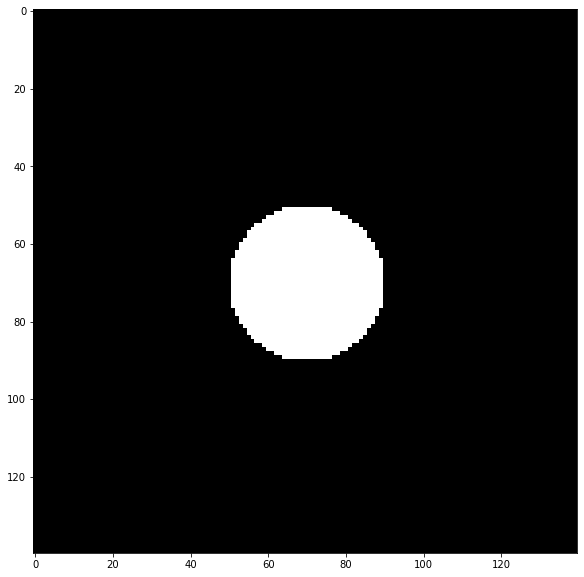

In [399]:
from skimage.draw import circle_perimeter, circle

def my_circle_border(r, windowssize=140):
    circ = np.zeros((windowssize, windowssize), dtype=np.bool)
    rr, cc = circle(windowssize/2, windowssize/2, r)
    circ[rr, cc] = True
    startp = get_left_start_points(circ)
    print('startp', startp)

    circ_border = moore_neighbor_tracing(circ, startp, (startp[0]-1,startp[1]-1))
    return circ_border

def my_circle(r, windowssize=140):
    circ = np.zeros((windowssize, windowssize), dtype=np.bool)
    rr, cc = circle(windowssize/2, windowssize/2, r)
    circ[rr, cc] = True

    return circ


circ = my_circle(20)
plt.imshow(circ, cmap=plt.cm.bone)


startp (51, 70)
possible trouble
adapt_border: [(51, 70), (51, 69), (51, 68), (51, 67), (51, 66), (51, 65), (51, 64), (52, 63), (52, 62), (53, 61), (53, 60), (54, 59), (55, 58), (55, 57), (56, 56), (57, 55), (58, 55), (59, 54), (60, 53), (61, 53), (62, 52), (63, 52), (64, 51), (65, 51), (66, 51), (67, 51), (68, 51), (69, 51), (70, 51), (71, 51), (72, 51), (73, 51), (74, 51), (75, 51), (76, 51), (77, 52), (78, 52), (79, 53), (80, 53), (81, 54), (82, 55), (83, 55), (84, 56), (85, 57), (85, 58), (86, 59), (87, 60), (87, 61), (88, 62), (88, 63), (89, 64), (89, 65), (89, 66), (89, 67), (89, 68), (89, 69), (89, 70), (89, 71), (89, 72), (89, 73), (89, 74), (89, 75), (89, 76), (88, 77), (88, 78), (87, 79), (87, 80), (86, 81), (85, 82), (85, 83), (84, 84), (83, 85), (82, 85), (81, 86), (80, 87), (79, 87), (78, 88), (77, 88), (76, 89), (75, 89), (74, 89), (73, 89), (72, 89), (71, 89), (70, 89), (69, 89), (68, 89), (67, 89), (66, 89), (65, 89), (64, 89), (63, 88), (62, 88), (61, 87), (60, 87), (5

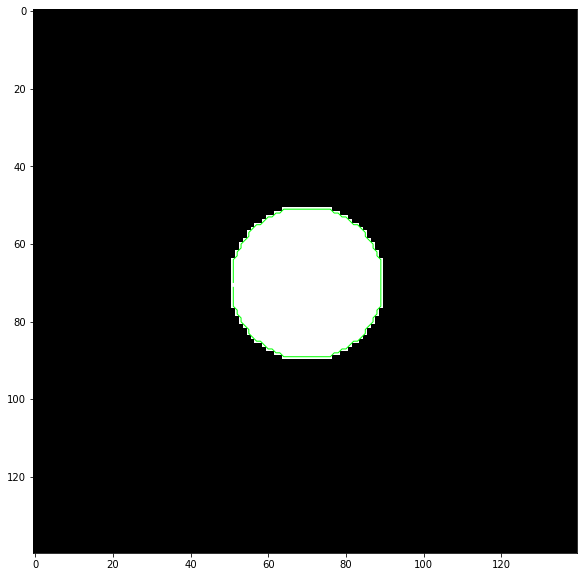

In [400]:
fg, ax = plt.subplots()
adaptcirc_mask = my_circle(20)
adaptcirc_border = my_circle_border(20)
adapt_border = adaptive_border_marching(adaptcirc_border, 50, 0.5)
print('adapt_border:', adapt_border)
adapt_path = Path(adapt_border)
adapt_patch = PathPatch(adapt_path, fill=False, ec='lime')
ax.imshow(adaptcirc_mask, cmap=plt.cm.bone)
ax.add_patch(adapt_patch)

startp (51, 70)
possible trouble
breaked
startp (43, 70)
possible trouble
breaked
startp (35, 70)
possible trouble
breaked
startp (27, 70)
possible trouble
breaked
startp (19, 70)
possible trouble
breaked
startp (51, 70)
possible trouble
startp (43, 70)
possible trouble
startp (35, 70)
possible trouble
startp (27, 70)
possible trouble
startp (19, 70)
possible trouble


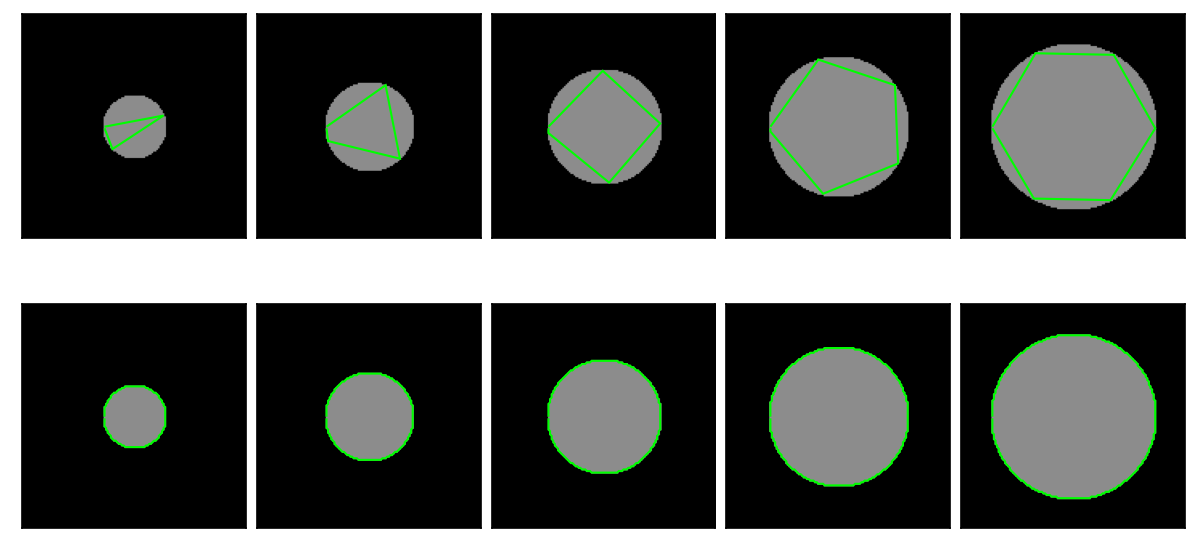

In [401]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (10,5)

fig, axs = plt.subplots(nrows=2, ncols=5, dpi=150)
[axii.get_yaxis().set_visible(False) for axi in axs for axii in axi] # hide y
[axii.get_xaxis().set_visible(False) for axi in axs for axii in axi] # hide y

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

my_cmap = plt.get_cmap('gray')
my_cmap = truncate_colormap(my_cmap, 0, 0.55)


STEP_LENGTH = 50
window_size = 140



for i in range(5):
    circ_mask = my_circle(20+i*8)
    circ_border = my_circle_border(20+i*8)
    nonadapt_border = non_adaptive(circ_border, STEP_LENGTH)
    nonadapt_path = Path(nonadapt_border)
    nonadapt_patch = PathPatch(nonadapt_path, fill=False, ec='lime')

    axs[0][i].imshow(circ_mask, cmap=my_cmap)
    axs[0][i].add_patch(nonadapt_patch)
    
    
for i in range(5):
    circ_mask = my_circle(20+i*8)
    circ_border = my_circle_border(20+i*8)
    adapt_border = adaptive_border_marching(circ_border, STEP_LENGTH, lambda0 = 0.5)
    adapt_path = Path(adapt_border)
    adapt_patch = PathPatch(adapt_path, fill=False, ec='lime')
    
    axs[1][i].imshow(circ_mask, cmap=my_cmap)
    axs[1][i].add_patch(adapt_patch)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [402]:
# # def get_moore_nextneighbor(point, mask):
# #     directions = [(0,-1),(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1)]
# #     for i, dire in enumerate(directions):
# #         new = tuple(np.add(point,dire))
# #         if mask[new[0]][new[1]]:
# #             last = tuple(np.add(point,directions[i-1]))
# #             return (new,last)
    
# def get_border_from_startpoint(point, mask):
#     #directions = [(0,-1),(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1)]
#     directions = [(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1)]
#     border = [point]
#     while border.count(point) == 1:
#         for dire in directions:
#             new = tuple(np.add(border[-1],dire))
# #             maks = make_mask_from_border(border, mask.shape)
# #             plt.imshow(maks)
# #             plt.show()
#             print('new=',new)
#             print(mask[new[0]][new[1]])
#             if (new == point) and len(border)>3:
#                 return border
#             if mask[new[0]][new[1]] and ((new not in border) and (new != point)):
#                 border.append(new)
#     return border
                



        


# pass



In [403]:
# gaussian smoothing 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
# TODO: how much sigma to use
def dcm_gauss(dcm):
    intercept = int(dcm.RescaleIntercept) # i need these from the dicomheader to calculate HU as HU = grayvalue * slope + intercept
    slope = int(dcm.RescaleSlope)
    pixel_spacing = float(dcm.PixelSpacing[0])
    mypixels = dcm.pixel_array * slope + intercept
    gaussed = gaussian_filter(mypixels, sigma=pixel_spacing)
    return gaussed

In [404]:
# gray level tresholding
def gray_level_tresholding(gaussed):
    tresholded = gaussed.copy()
    mask = (tresholded > -500) | (tresholded < -980)
    tresholded[mask] = -10000
    return tresholded

In [405]:
# floodfill non-lung region
def floodfill_nonlung_region(tresholded):
    filled = tresholded.copy()
    xmax, ymax = filled.shape
    i = 0
    flood_fill(filled, (i, 0), -3000, tolerance=2500,connectivity=1, inplace=True) # int(ymax*0.15)
    flood_fill(filled, (i, ymax-1), -3000, tolerance=2500,connectivity=1, inplace=True) # int(ymax*0.85)
    flood_fill(filled, (xmax-1, ymax-1), -3000, tolerance=2500,connectivity=1, inplace=True) # int(xmax*0.85)
    flood_fill(filled, (xmax-1, i), -3000, tolerance=2500,connectivity=1, inplace=True) # int(xmax*0.85)

    filled[filled == -10000] = -1024
    filled[filled == -3000] = -1024
    lung_mask = (filled != -1024)
    non_lung_mask = (filled == -1024)
    return lung_mask

In [406]:
def get_borders(lung_mask):
    lp = get_left_start_points(lung_mask)
    rp = get_right_start_points(lung_mask)
    print('lp, rp:',lp,rp)
    left_border = moore_neighbor_tracing(lung_mask, lp, (lp[0]-1,lp[1]-1))
    right_border = moore_neighbor_tracing(lung_mask, rp, (rp[0]+1,rp[1]-1))

    return left_border, right_border

In [523]:
def merge_borders(left, right, shape):
    return np.logical_or(make_mask_from_border(left, shape), make_mask_from_border(right, shape))

def merge_masks(left, right):
    return np.logical_or(left,right)

In [515]:
def get_mask_from_maskborders(bordermask):
    lp = get_left_start_points(bordermask)
    rp = get_right_start_points(bordermask)
    print('lp, rp:',lp,rp)
    lp = (lp[0]+1, lp[1])
    rp = (rp[0]-1, rp[1])
    mask = flood_fill(bordermask.astype('int8') , seed_point=lp, new_value=1, connectivity=1) 
    mask = flood_fill(bordermask.astype('int8'), seed_point=rp, new_value=1, connectivity=1) 
    
    return mask.astype('bool')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


IndexError: too many indices for array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [528]:
from skimage.segmentation import flood
zeross = np.zeros((15,15))
asdasd = make_mask_from_border(my_circle_border(5, 15), (15,15))


floodmask = get_mask_from_maskborders(asdasd)


print(floodmask)



startp (3, 7)
possible trouble
lp, rp: (3, 7) (12, 7)
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False  True  True  True  True False False
  False False False]
 [False False False False  True  True  True  True  True  True  True  True
  False False False]
 [False False False False  True  True  True  True  True  True  True  True
  False False False]
 [False False False  True  True  True  True  True  True  True  True  True
   True False False]
 [False False False  True  True  True  True  True  True  True  True  True
   True False False]
 [False False False  True  True  True  True  True  True  True  True  True
   True False False]
 [False False False  True  True  True  True  True  True  True  True  True
   True False Fal

In [579]:
%%time
#plt.rcParams["figure.figsize"] = (14,2)
accs= []
adaptive_results = []

for i in range(28):

    #fig, axs = plt.subplots(nrows=1, ncols=7, dpi=150)

    dcm = pydicom.dcmread("../data/dcms/" + names[i] + ".dcm")
    gaussed = dcm_gauss(dcm)
    #axs[0].imshow(gaussed)
    tresholded = gray_level_tresholding(gaussed)
    #axs[1].imshow(tresholded)
    filled = floodfill_nonlung_region(tresholded)
    #axs[2].imshow(filled)
    #axs.imshow(filled)

    leftb, rightb = get_borders(filled)
    #axs[3].imshow(merge_borders(leftb, rightb, filled.shape))

    lnonadapt = non_adaptive(leftb)
    rnonadapt = non_adaptive(rightb)

    #axs[4].imshow(merge_borders(lnonadapt, rnonadapt, filled.shape))
    
    
    #connect_nd


    ladapt = adaptive_border_marching(leftb)
    radapt = adaptive_border_marching(rightb)
    

    
    
    adaptl = make_mask_from_nonadaptive_border(ladapt, filled.shape)
    adaptr = make_mask_from_nonadaptive_border(radapt, filled.shape)
    #axs[3].imshow(adaptl)
    #axs[4].imshow(adaptr)

    adapt = merge_masks(adaptl,adaptr)
    adapt = ~get_mask_from_maskborders(adapt)
    #axs[5].imshow(adapt)
    #axs[5].set_xlabel(str(i))
    #axs[6].imshow(image_masks[i])
    #axs[6].set_xlabel(names[i])
    adaptive_results.append(adapt)
    adaptfilledarea = get_filledarea_ratio(adapt) * 100
    maskfilledarea = get_filledarea_ratio(image_masks[i]) * 100
    accuracy = adaptfilledarea/maskfilledarea
    accs.append(accuracy)
    print(i, adaptfilledarea, maskfilledarea, accuracy*100)



lp, rp: (170, 256) (373, 256)
possible trouble
possible trouble
breaked
breaked
lp, rp: (170, 256) (373, 256)
0 6.5235137939453125 7.3040008544921875 89.31425288556954
lp, rp: (169, 256) (374, 256)
possible trouble
possible trouble
breaked
breaked
lp, rp: (169, 256) (374, 256)
1 6.5338134765625 7.309722900390625 89.3852416240476
lp, rp: (170, 256) (372, 256)
possible trouble
possible trouble
breaked
lp, rp: (170, 256) (372, 256)
2 6.45751953125 7.2620391845703125 88.92157377738089
lp, rp: (171, 256) (368, 256)
possible trouble
possible trouble
breaked
lp, rp: (171, 256) (368, 256)
3 6.526947021484375 7.50732421875 86.9410569105691
lp, rp: (169, 256) (374, 256)
possible trouble
possible trouble
breaked
breaked
lp, rp: (169, 256) (374, 256)
4 6.5662384033203125 7.3520660400390625 89.3114720074716
lp, rp: (153, 256) (336, 256)
possible trouble
possible trouble
breaked
breaked
lp, rp: (153, 256) (336, 256)
5 5.219268798828125 5.8238983154296875 89.618130608502
lp, rp: (154, 256) (335, 256)

In [554]:
errors = [100-elem*100 for elem in accs]
[(i,100-elem*100) for i,elem in enumerate(accs)]

[(0, 10.685747114430455),
 (1, 10.614758375952405),
 (2, 11.078426222619115),
 (3, 13.058943089430898),
 (4, 10.688527992528407),
 (5, 10.381869391498),
 (6, 9.387700712905584),
 (7, 12.840050377833762),
 (8, 11.482855680655064),
 (9, 15.82822668756829),
 (10, 18.05196309307803),
 (11, 20.722513975944437),
 (12, 14.25958469318222),
 (13, 15.659661412726209),
 (14, 14.17961765919405),
 (15, 12.423636565589248),
 (16, 14.818891334800881),
 (17, 16.41668939187346),
 (18, 12.697927492816532),
 (19, 12.840037200651011),
 (20, 11.821500624459603),
 (21, 12.848408992442117),
 (22, 9.578479563665738),
 (23, 9.375592491942115),
 (24, 10.90290218559656),
 (25, 11.402571565412813),
 (26, 10.44151050539466),
 (27, 8.551023525817286)]

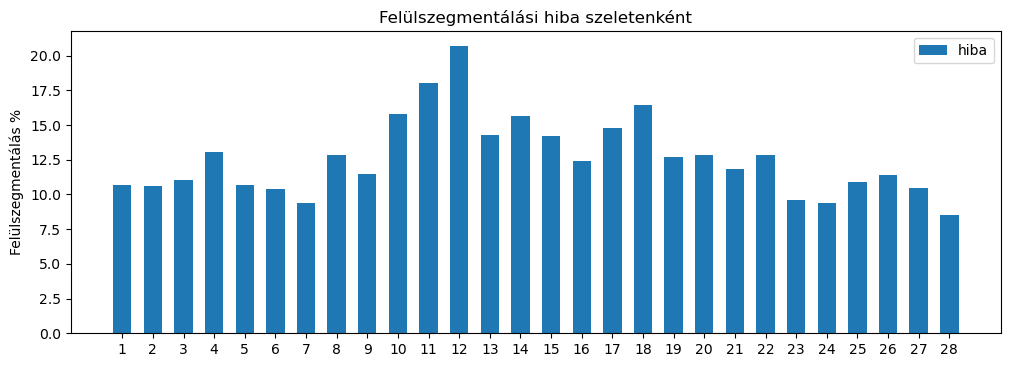

In [585]:
plt.rcParams["figure.figsize"] = (12,4)
fig, ax = plt.subplots(dpi=100)
x = np.arange(1,28+1)
width = 0.6  # the width of the bars
bar = ax.bar(x, errors, width, label='hiba')

ax.set_ylabel('Felülszegmentálás %')
ax.set_title('Felülszegmentálási hiba szeletenként')
ax.set_xticks(x)
ax.legend()

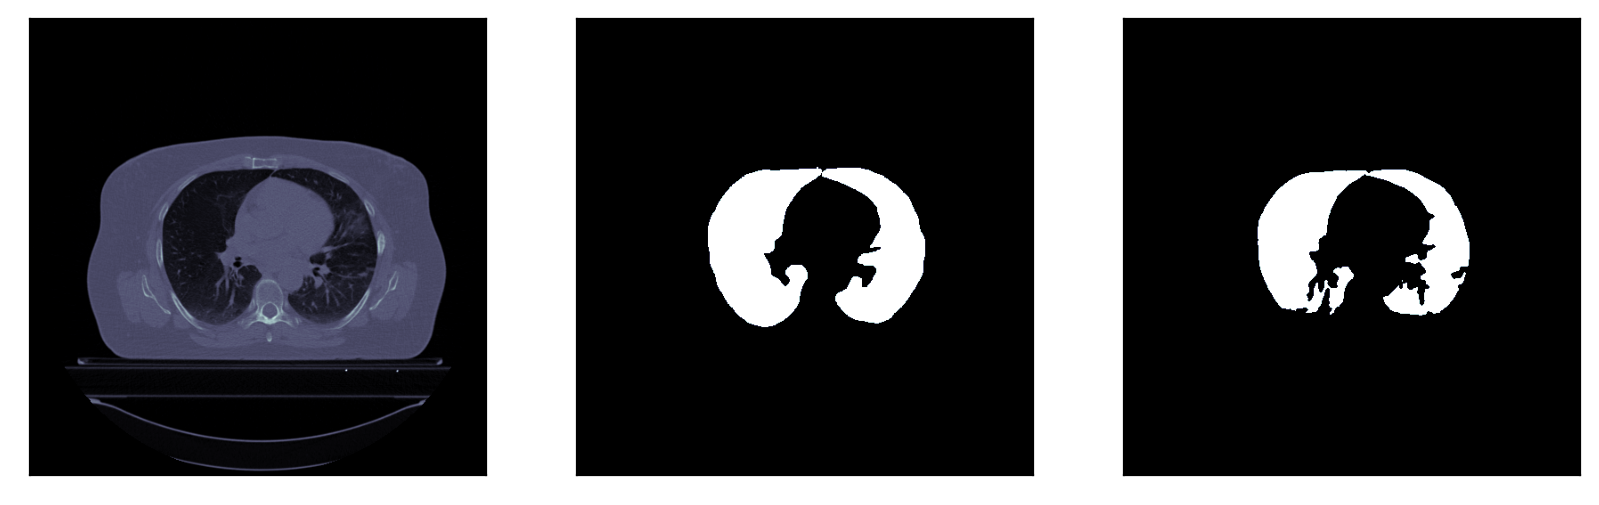

In [576]:

fig, axs = plt.subplots(1,3,dpi=200)
[axi.get_yaxis().set_visible(False) for axi in axs] # hide y
[axi.get_xaxis().set_visible(False) for axi in axs] # hide y
axs[0].imshow(images[11],cmap=plt.cm.bone)
axs[1].imshow(image_masks[11],cmap=plt.cm.bone)
axs[2].imshow(adaptive_results[11],cmap=plt.cm.bone)

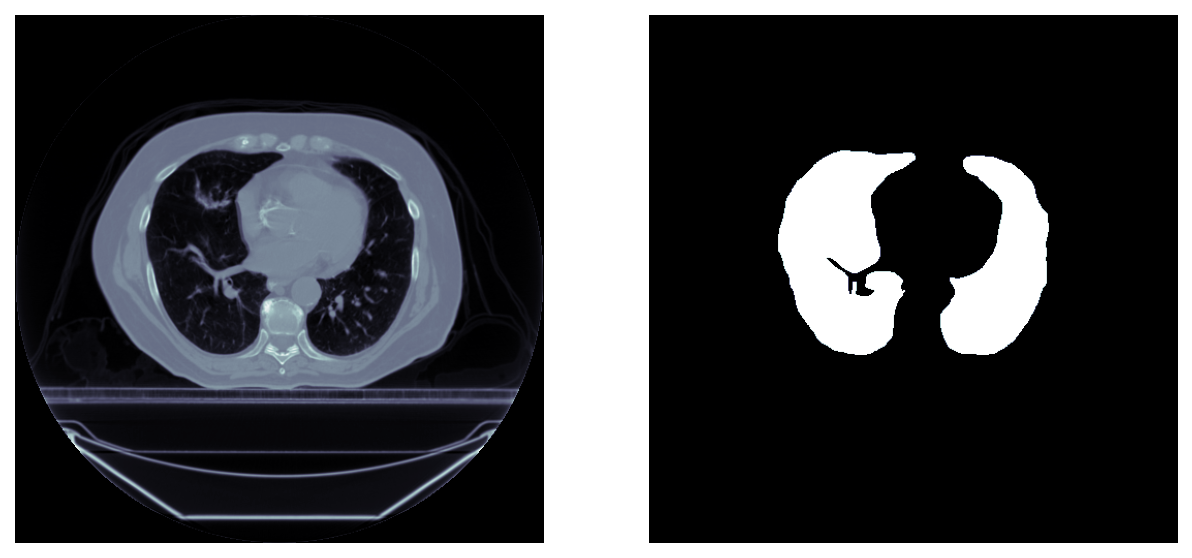

In [412]:
plot_two_cols(images[26], image_masks[26])

In [584]:
100 - sum(accs) / len(accs) * 100

12.60855778285746